# Select and download SHARP data

In [1]:
from __future__ import division, print_function
import os.path
import matplotlib.pyplot as plt
from astropy.io import fits
import drms
%matplotlib inline

## Selecting the data

In this example, we select a record from the [Space-weather Active Region Patch](http://jsoc.stanford.edu/doc/data/hmi/sharp/sharp.htm) (SHARP) series, and download some of its data files. We use the flux-weighted center of SHARP 4315 to select the record that is closest to the central meridian. Additional metadata, like SDO's LoS velocity or WCS keywords are used when creating plots of the downloaded data.

In [2]:
series = 'hmi.sharp_720s'
sharpnum = 4315
segments = ['magnetogram', 'field', 'continuum', 'Dopplergram']
kwlist = ['T_REC', 'LON_FWT', 'OBS_VR', 'CROTA2',
          'CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2']

Create DRMS client and query metadata.

Note that you need to register your email address at JSOC, in order to be able to submit export requests. This can be very easily done on the [JSOC email registration](http://jsoc.stanford.edu/ajax/register_email.html) webpage. You then need to replace the `email='name@example.com'` argument below with your own registered email address.

In [3]:
c = drms.Client(email='name@example.com', verbose=True)
k = c.query('%s[%d]' % (series, sharpnum), key=kwlist, rec_index=True)

Find the record that is clostest to the central meridian, by using the minimum of the patch's absolute longitude:

In [4]:
rec_cm = k.LON_FWT.abs().argmin()
k_cm = k.loc[rec_cm]
t_cm = drms.to_datetime(k.T_REC[rec_cm])
print(rec_cm, '@', k.LON_FWT[rec_cm], 'deg')
print('Timestamp:', t_cm)

hmi.sharp_720s[4315][2014.07.07_05:12:00_TAI] @ -0.038282 deg
Timestamp: 2014-07-07 05:12:00


Before downloading the corresponding data files, we first check if the files were already downloaded. For this we create a list of file names and check if they already exist, before submitting the data export request.

In [5]:
t_cm_str = t_cm.strftime('%Y%m%d_%H%M%S_TAI')
fname_mask = '{series}.{sharpnum}.{tstr}.{segment}.fits'
fnames = {
    s: fname_mask.format(
        series=series, sharpnum=sharpnum, tstr=t_cm_str, segment=s)
    for s in segments}

download_segments = []
for k, v in fnames.items():
    if not os.path.exists(v):
        download_segments.append(k)

We now submit the export request and download all files that were not downloaded in any previous run:

In [6]:
if download_segments:
    exp_query = '%s{%s}' % (rec_cm, ','.join(download_segments))
    r = c.export(exp_query)
    dl = r.download('.')

    record: hmi.sharp_720s[4315][2014.07.07_05:12:00_TAI]{magnetogram}
  filename: magnetogram.fits
  -> "hmi.sharp_720s.4315.20140707_051200_TAI.magnetogram.fits"
    record: hmi.sharp_720s[4315][2014.07.07_05:12:00_TAI]{Dopplergram}
  filename: Dopplergram.fits
  -> "hmi.sharp_720s.4315.20140707_051200_TAI.Dopplergram.fits"
    record: hmi.sharp_720s[4315][2014.07.07_05:12:00_TAI]{continuum}
  filename: continuum.fits
  -> "hmi.sharp_720s.4315.20140707_051200_TAI.continuum.fits"
    record: hmi.sharp_720s[4315][2014.07.07_05:12:00_TAI]{field}
  filename: field.fits
  -> "hmi.sharp_720s.4315.20140707_051200_TAI.field.fits"


In case the files were downloaded with additional keyword data in their headers, we need to take care of any non-standard FITS keywords, to avoid errors when reading these files using `astropy.io.fits`. For this reason, we define a short function that takes care of these keywords and returns the data from the compressed data unit.

In [7]:
def read_fits_data(fname):
    """Reads FITS data and fixes/ignores any non-standard FITS keywords."""
    hdulist = fits.open(fname)
    hdulist.verify('silentfix+warn')
    return hdulist[1].data

We can now finally read the data from the downloaded FITS files:

In [8]:
mag = read_fits_data(fnames['magnetogram'])
babs = read_fits_data(fnames['field'])
cont = read_fits_data(fnames['continuum'])
dopp = read_fits_data(fnames['Dopplergram'])

## Preparing the data for plotting

We start with subtracting SDO's LoS velocity from the Dopplergram:

In [9]:
dopp -= k_cm.OBS_VR

We now convert the coordinates of the patch from pixel coordinates to helioprojective-cartesian cordinates, by using the WCS keywords.

In [10]:
ny, nx = mag.shape
xmin = (1 - k_cm.CRPIX1)*k_cm.CDELT1 + k_cm.CRVAL1
xmax = (nx - k_cm.CRPIX1)*k_cm.CDELT1 + k_cm.CRVAL1
ymin = (1 - k_cm.CRPIX2)*k_cm.CDELT2 + k_cm.CRVAL2
ymax = (ny - k_cm.CRPIX2)*k_cm.CDELT2 + k_cm.CRVAL2

One issue, not handled by this transformation, is image rotation. For exact results, this would need us to either remap the data on a different grid, or use a rotated coordinate system for plotting the data. Luckily, the rotation angle of HMI images, i.e. `CROTA2`, is usally very close to 180°. So we can well approximate the rotation by just flipping the image axes.

In [11]:
if abs(180 - k_cm.CROTA2) < 0.1:
    mag = mag[::-1, ::-1]
    babs = babs[::-1, ::-1]
    cont = cont[::-1, ::-1]
    dopp = dopp[::-1, ::-1]
    xmin, xmax = -xmax, -xmin
    ymin, ymax = -ymax, -ymin
else:
    raise RuntimeError('CROTA2 = %.2f value not supported.' % k_cm.CROTA2)

We can now compute the extent of the image in arcsecs, which will be used when plotting the images.

In [12]:
extent = (xmin - abs(k_cm.CDELT1)/2, xmax + abs(k_cm.CDELT1)/2,
          ymin - abs(k_cm.CDELT2)/2, ymax + abs(k_cm.CDELT2)/2)

## Plotting the image data

We change some matplotlib options to make plot commands less verbose:

In [13]:
plt.rc('mathtext', default='regular')
plt.rc('image', origin='lower', interpolation='nearest', cmap='gray')

And finally create the plots and save the figure as PDF and PNG:

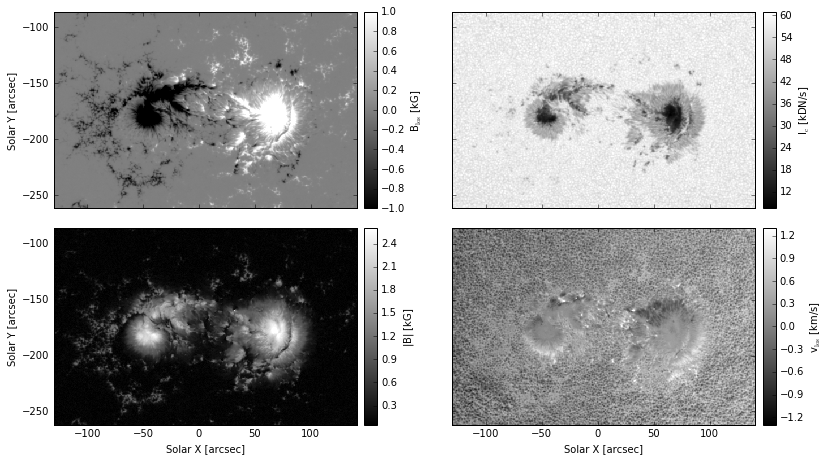

In [14]:
fig = plt.figure(figsize=(12, 6.75))
gs = plt.GridSpec(2, 5, width_ratios=[1, 0.1, 0.1, 1, 0.1])
ax = [fig.add_subplot(gsi, anchor='E')
      for gsi in [gs[0, 0], gs[0, 3], gs[1, 0], gs[1, 3]]]
cax = [fig.add_subplot(gsi, anchor='W', aspect=15)
      for gsi in [gs[0, 1], gs[0, 4], gs[1, 1], gs[1, 4]]]

ax_mag, cax_mag = ax[0], cax[0]
im_mag = ax_mag.imshow(mag/1e3, extent=extent, vmin=-1, vmax=1)
cb_mag = plt.colorbar(im_mag, cax_mag, label='$B_{\mathrm{los}}$ [kG]')

ax_cont, cax_cont = ax[1], cax[1]
im_cont = ax_cont.imshow(cont/1e3, extent=extent, vmax=61)
cb_cont = plt.colorbar(im_cont, cax_cont, label='$I_{\mathrm{c}}$ [kDN/s]')

ax_babs, cax_babs = ax[2], cax[2]
im_babs = ax_babs.imshow(babs/1e3, extent=extent, vmin=0.05, vmax=2.6)
cb_babs = plt.colorbar(im_babs, cax_babs, label='$|B|$ [kG]')

ax_dopp, cax_dopp = ax[3], cax[3]
im_dopp = ax_dopp.imshow(dopp/1e3, extent=extent, vmin=-1.3, vmax=1.3)
cb_dopp = plt.colorbar(im_dopp, cax_dopp, label='$v_{\mathrm{los}}$ [km/s]')

ax_mag.set_xticklabels([])
ax_cont.set_xticklabels([])
ax_cont.set_yticklabels([])
ax_dopp.set_yticklabels([])
ax_babs.set_xlabel('Solar X [arcsec]')
ax_dopp.set_xlabel('Solar X [arcsec]')
ax_mag.set_ylabel('Solar Y [arcsec]')
ax_babs.set_ylabel('Solar Y [arcsec]')

for axi in ax:
    axi.set_xlim(-130, 141)
    axi.set_ylim(-262, -86)

fig.subplots_adjust(
    left=0.07, bottom=0.10, right=0.94, top=0.95, wspace=0.05, hspace=0.10)
plt.draw()

fig.savefig('sharp_imgdata.pdf', dpi=200)
fig.savefig('sharp_imgdata.png', dpi=200)

plt.show()